<a href="https://colab.research.google.com/github/mx-drn/bachelor_thesis_pseudo_labeling/blob/main/first_implementation_of_BERT_on_kaggle_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 4.1 MB/s 
     |████████████████████████████████| 636 kB 27.9 MB/s 
     |████████████████████████████████| 895 kB 28.2 MB/s 
     |████████████████████████████████| 3.3 MB 38.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import warnings
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)

In [4]:
#print(torch.__version__)

In [5]:
# needed imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import nltk
import time


import transformers
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from textwrap import wrap
#import pytorch_lightning as pl

from pylab import rcParams
from matplotlib import rc
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# Use GPU
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Sun Aug  1 16:17:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Get an Overview over the data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# import data
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Data/kaggle_data.csv", names=['label', 'article'], encoding='latin-1')

print("Overall distribution of the data and labels:")
print(data['label'].value_counts(ascending=True))
print()

all_lens = {
    'positive': [],
    'negative': [],
    'neutral': []
}

for index, row in data.iterrows():
    all_lens[row['label']].append(len(row['article']))
print("General dataset size: " + str(len(data)))

print("\nPositive Sentiment Mean Article Length: " + str(sum(all_lens['positive'])/len(all_lens['positive'])))
print("Positive Sentiment Max Article Length: " + str(max(all_lens['positive'])))
print()
print("Neutral Sentiment Mean Article Length: " + str(sum(all_lens['neutral'])/len(all_lens['neutral'])))
print("Neutral Sentiment Max Article Length: " + str(max(all_lens['neutral'])))
print()
print("Negative Sentiment Mean Article Length: " + str(sum(all_lens['negative'])/len(all_lens['negative'])))
print("Negative Sentiment Max Article Length: " + str(max(all_lens['negative'])))

Overall distribution of the data and labels:
negative     604
positive    1363
neutral     2879
Name: label, dtype: int64

General dataset size: 4846

Positive Sentiment Mean Article Length: 135.64783565663976
Positive Sentiment Max Article Length: 298

Neutral Sentiment Mean Article Length: 125.07224730809308
Neutral Sentiment Max Article Length: 315

Negative Sentiment Mean Article Length: 125.75662251655629
Negative Sentiment Max Article Length: 296


## Have a look at the data

In [9]:
print('Article:')
print(data.iloc[13].article + "\n")
print('Label:')
print(data.iloc[13].label)

Article:
Finnish Talentum reports its operating profit increased to EUR 20.5 mn in 2005 from EUR 9.3 mn in 2004 , and net sales totaled EUR 103.3 mn , up from EUR 96.4 mn .

Label:
positive


In [10]:
label_names = list(set(data['label'].values))
label_names.sort()

print("All possible labels: " + str(label_names))

All possible labels: ['negative', 'neutral', 'positive']


### Test Data if BERT cased or uncased makes sense

In [11]:
uppercased_words_found = []

for index, row in data.iterrows():
    temp_article = row['article']
    
    for word in temp_article:
        if len(word)>1 and word == word.upper():
            uppercased_words_found.append(word)
            
print(uppercased_words_found)

[]


## Preprocessing

In [12]:
# normalize whitespace
data['article'] = data['article'].apply(lambda x: " ".join(x.split()))

# remove punctuations except ?
data['article'] = data['article'].apply(lambda x: re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', x))

## Convert labels to more understandable -1,0,1 format

In [13]:
new_labels = {
    'positive': 2,
    'negative': 0,
    'neutral': 1
}
for index, row in data.iterrows():
  data['label'].iloc[index] = new_labels[row['label']]
data.head(2)

,label,article
0,1,"According to Gran , the company has no plans..."
1,1,Technopolis plans to develop in stages an area...


## Build Pseudo Labeling Dataset

In [14]:
def get_dataclass_distribution_of_unlabeled_data(data_class_size, X, y, random_state):
  labeled_data_distribution = data_class_size/len(X)

  X_unlabeled, X_labeled, y_unlabeled, y_labeled = train_test_split(X, y, test_size=labeled_data_distribution, random_state=random_state)

  return {
      'labeled_data': X_labeled,
      'labeled_data_labels': y_labeled,
      'unlabeled_data': X_unlabeled,
      'unlabeled_data_labels': y_unlabeled
  }

## Set tokenizer

In [15]:
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")
# Uncased -> Because case may express the sentiment but no uppercase word are given in the dataset as mentioned earlier

### Choose maximum token length

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


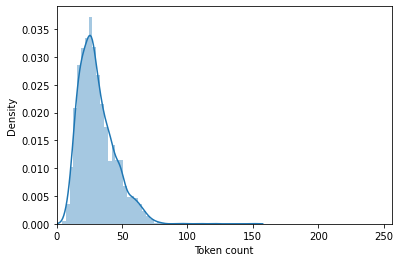

In [16]:
token_lens = []
for txt in data.article:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))
    
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [17]:
MAX_LEN = 100
BATCH_SIZE = 8
SEED = 1210

# Split data into training and validation datasets

In [18]:
def split_data_into_train_test_val(X, y, val_size, random_state):
    X_reduced, X_test, y_reduced, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_reduced, y_reduced, test_size=val_size, random_state=random_state)
    
    return {
        'train': {
            'X': list(X_train),
            'y': list(y_train)
        },
        'val': {
            'X': list(X_val),
            'y': list(y_val)
        },
        'test': {
            'X': list(X_test),
            'y': list(y_test)
        }
    }

In [19]:
split_data = split_data_into_train_test_val(data['article'].values, data['label'].values, val_size=0.2, random_state=SEED)

In [20]:
X_train = split_data['train']['X']
X_test = split_data['test']['X']
X_val = split_data['val']['X']
y_train = split_data['train']['y']
y_test = split_data['test']['y']
y_val = split_data['val']['y']

import collections, numpy



print("Distribution train: ")
print(collections.Counter(y_train))
print("\nDistribution val: ")
print(collections.Counter(y_val))
print("\nDistribution test: ")
print(collections.Counter(y_test))

Distribution train: 
Counter({1: 2068, 2: 999, 0: 421})

Distribution val: 
Counter({1: 520, 2: 234, 0: 119})

Distribution test: 
Counter({1: 291, 2: 130, 0: 64})


### Build data class for pytorch-Dataloader usage (Map-style dataset)

In [21]:
class BertData():
    def __init__(self, article, label):
        self.article = article
        self.label = label
        self.tokenizer = tokenizer
        self.max_len = MAX_LEN

    def __len__(self):
        return len(self.article)
    
    def __getitem__(self, idx):
        article = str(self.article[idx])
        article = ' '.join(article.split())

        inputs = self.tokenizer.encode_plus(
            article,
            None,
            add_special_tokens = True,
            max_length = MAX_LEN,
            padding='max_length',
            truncation='longest_first'
        )

        ids = torch.tensor(inputs['input_ids'], dtype=torch.long)
        mask = torch.tensor(inputs['attention_mask'], dtype=torch.long)
        token_type_ids = torch.tensor(inputs['token_type_ids'], dtype=torch.long)
        labels = torch.tensor(self.label[idx], dtype=torch.long)

        return {'article': article,
                'ids': ids,
                'mask': mask,
                'token_type_ids': token_type_ids,
                'targets': labels
                }

In [22]:
training_set = BertData(article=X_train, label=y_train)
validation_set = BertData(article=X_val, label=y_val)
test_set = BertData(article=X_test, label=y_test)

### Set pytorch data loader

In [23]:
def get_dataloader(training_set, validation_set, test_set):
    train_dataloader = DataLoader(
            training_set,
            shuffle=False,
            batch_size=BATCH_SIZE,
            num_workers=4
            )
    val_dataloader = DataLoader(
            validation_set,
            shuffle=False,
            batch_size=BATCH_SIZE,
            num_workers=4
            )
    test_dataloader = DataLoader(
            test_set,
            shuffle=False,
            batch_size=BATCH_SIZE,
            num_workers=4
            )
    
    return train_dataloader, val_dataloader, test_dataloader

# BERT Model

## Build PyTorch Pipeline

In [24]:
#train_dataloader, val_dataloader, test_dataloader = get_dataloader(X_train, y_train, X_val, y_val, X_test, y_test)

## Set Hyperparameters

In [25]:
EPOCHS = 10
VALIDATION_SPLIT = 0.2
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-5

In [26]:
class ClassicalBertClassifier(nn.Module):
    def __init__(self):
        super(ClassicalBertClassifier, self).__init__()
        
        self.bert = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.drop = nn.Dropout(0.3)
        
        # BERT-base has 768 Output dimensions --> Map to 3 -> negative, neutral, positive
        self.out = nn.Linear(768, 3)
        self.all_targets = []
        
        # Binary Cross Entropy Loss combined with Sigmoid Layer
        self.train_loss_fn = nn.BCEWithLogitsLoss()
        self.valid_loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, ids, mask, token_type_ids) -> torch.Tensor:
        _, output = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
        output = self.drop(output)
        output = self.out(output)
        return output

    

## Set model

In [27]:
# now in training loop

# Training

### Define optimizer, loss function and scheduler

In [28]:
# now in training loop

### Define traditional training epoch (supervised)

In [29]:
def traditional_train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples):

  model = model.train()
  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["ids"].to(device)
    attention_mask = d["mask"].to(device)
    targets = d["targets"].to(device)
    token_type_ids = d['token_type_ids'].to(device)

    outputs = model(
      ids=input_ids,
      mask=attention_mask,
      token_type_ids=token_type_ids)
    
    _, preds = torch.max(outputs, dim=1)

    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    # set grad to 0
    optimizer.zero_grad()
    
    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # avoid exploding gradient

    optimizer.step()

  scheduler.step()


  return correct_predictions.double() / n_examples, np.mean(losses)

## Define traditional eval epoch

In [51]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["ids"].to(device)
      attention_mask = d["mask"].to(device)
      targets = d["targets"].to(device)
      token_type_ids = d['token_type_ids'].to(device)

      outputs = model(
        ids=input_ids,
        mask=attention_mask,
        token_type_ids=token_type_ids)
      
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

## Define Pseudo Labeling Method

In [52]:
def generate_pseudo_label(unlabeled_dataset, model):
  # set model to eval mode
  model.eval()
  
  pseudo_labels = []

  for unlabeled_article in unlabeled_dataset:
    # prepare data fro model
    inputs = tokenizer.encode_plus(
            unlabeled_article,
            max_length=MAX_LEN,
            add_special_tokens=True,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

    ids = inputs['input_ids'].to(device)
    mask = inputs['attention_mask'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)

    # calculate model outputs
    output = model(
      ids=ids,
      mask=mask,
      token_type_ids=token_type_ids)
    
    # calculate pseudo labels
    _, pred = torch.max(output, dim=1)

    pseudo_labels.append(pred.item())
  
  return pseudo_labels

## Define Naive Semi supervised deep learning training epoch

In [53]:
def nssdl_train_epoch(
  model,
  unlabeled_dataset,
  loss_fn,
  optimizer,
  scheduler,
  device,
  n_examples):

  # apply pseudo labeling
  # 1. guess pseudo label
  # 2. BertData()
  # 3. DataLoader(BertData(PL))
  # 4. concat

  pseudo_labels = generate_pseudo_label(unlabeled_dataset=unlabeled_dataset, 
                                        model=model)
  print(pseudo_labels[0])

  # Convert to BertData
  pseudo_labeled_dataset = BertData(article=unlabeled_dataset, 
                                    label=pseudo_labels)

  # Create PseudoLabel DataLoader
  pseudo_label_dataloader = DataLoader(
            pseudo_labeled_dataset,
            shuffle=False,
            batch_size=BATCH_SIZE,
            num_workers=4
            )

  model = model.train()
  losses = []
  correct_predictions = 0

  for d in pseudo_label_dataloader:
    input_ids = d["ids"].to(device)
    attention_mask = d["mask"].to(device)
    targets = d["targets"].to(device)
    token_type_ids = d['token_type_ids'].to(device)

    outputs = model(
      ids=input_ids,
      mask=attention_mask,
      token_type_ids=token_type_ids)
    
    _, preds = torch.max(outputs, dim=1)

    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # avoid exploding gradient

    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

## Define Naive Semi supervised deep eval training epoch

In [54]:
# Sharing same eval loader as traditional approach

## Generic Training Loop

In [55]:
from collections import defaultdict

def run_model_training(kind, model, train_dataloader, val_dataloader, loss_fn, 
                       optimizer, scheduler, training_set, validation_set, 
                       unlabeled_train_set, unlabeled_scheduler): # kind == 'traditional', 'NSSDL', 'MixMatch'
  best_accuracy = 0
  history = defaultdict(list)
  best_model = None

  # for early stopping: save val_loss from last epoch
  last_val_loss = None

  # for precise analysis save pl acc/loss and finetune acc/loss as well
  if kind == 'NSSDL':
    train_acc_pl = 0
    train_acc_fine_tune = 0
    train_loss_pl = 0
    train_loss_fine_tune = 0

  for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    if kind == 'traditional':
      train_acc, train_loss = traditional_train_epoch(
        model=model,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device,
        scheduler=scheduler,
        n_examples=len(training_set))
      
    if kind == 'NSSDL':
      if epoch == 0:
        # train initial model with labeled data
        temp_acc, temp_loss = traditional_train_epoch(
                model=model,
                data_loader=train_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                device=device,
                scheduler=scheduler,
                n_examples=len(training_set)
              )
        print(f'Initial acc: {temp_acc}     Initial loss: {temp_loss}' )
        
      # first train with pseudo labels
      train_acc_pl, train_loss_pl = nssdl_train_epoch(
                model=model,
                unlabeled_dataset=unlabeled_train_set,
                loss_fn=loss_fn,
                optimizer=optimizer,
                device=device,
                scheduler=unlabeled_scheduler,
                n_examples=len(unlabeled_train_set)
              )

      # fine tune model with labeled samples
      train_acc_fine_tune, train_loss_fine_tune = traditional_train_epoch(
                model=model,
                data_loader=train_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                device=device,
                scheduler=scheduler,
                n_examples=len(training_set)
              )
      
      train_loss = (train_loss_pl + train_loss_fine_tune)/2
      train_acc = (int(train_acc_pl) + int(train_acc_fine_tune))/2
      print("PL Loss: " + str(train_loss_pl) + " Finetune Loss: " + str(train_loss_fine_tune))
      print("PL acc: " + str(train_acc_pl) + " Finetune acc: " + str(train_acc_fine_tune))
    
    
    print(f'({kind}) Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      val_dataloader,
      loss_fn,
      device,
      len(validation_set))

    
    print(f'({kind}) Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if kind == 'NSSDL':
      history['train_acc_pl'].append(train_acc)
      history['train_acc_fine_tune'].append(train_acc_fine_tune)
      history['train_loss_pl'].append(train_loss_pl)
      history['train_loss_fine_tune'].append(train_loss_fine_tune)
      
    # early stopping:
    if (last_val_loss is not None) and (last_val_loss < val_loss):
      print("Early stopping executed due to increasing val_loss from " + str(last_val_loss) + " to " + str(val_loss))
      break

    last_val_loss = val_loss

    if val_acc > best_accuracy:
      best_model = model.state_dict()
      torch.save(model.state_dict(), kind+'_best_model_state.bin')
      best_accuracy = val_acc

  return best_model, history, best_accuracy

## Overall Training loop

In [57]:
FOLDS = 10
RANDOM_STATES = ['1210', '505', '2506', '1807', '1402', '107', '1803', '2405', '208', '2209']

overall_saving_dict = {
    'trad': [],
    'nssdl': [],
    'mixmatch': []
}

best_models = {
    'trad': [],
    'nssdl': [],
    'mixmatch': []
}


# set reasonable data manipulation classes
data_manipultation_classes = [50, 100, 250, 500, 2000]

for data_class in data_manipultation_classes:
  print("Data class of " + str(data_class) + " labeled samples per fold")
  print('-' * 50)
  print()



  for fold in range(FOLDS):
    print(f'Fold {fold + 1}/{FOLDS}')
    print('-' * 10)
    print()

    tradi_model = ClassicalBertClassifier()
    tradi_model = tradi_model.to(device)

    NSSDL_model = ClassicalBertClassifier()
    NSSDL_model = NSSDL_model.to(device)

    # set random_state
    random_state = int(str(data_manipultation_classes.index(data_class)+1) + RANDOM_STATES[fold])

    # set labeled- and unlabeled data and train-, val-, test data
    split_data = split_data_into_train_test_val(data['article'], data['label'], 0.2, random_state)

    X_train = split_data['train']['X']
    X_test = split_data['test']['X']
    X_val = split_data['val']['X']

    y_train = split_data['train']['y']
    y_test = split_data['test']['y']
    y_val = split_data['val']['y']

    data_dict = get_dataclass_distribution_of_unlabeled_data(data_class_size=data_class,
                                                             X=X_train, 
                                                             y=y_train, 
                                                             random_state=random_state)
    
    X_train_labeled = data_dict['labeled_data']
    X_train_unlabeled = data_dict['unlabeled_data']

    y_train_labeled = data_dict['labeled_data_labels']
    y_train_unlabeled = data_dict['unlabeled_data_labels'] # for testing purposes (maybe)

    # initialise BertData
    training_set = BertData(article=X_train_labeled, label=y_train_labeled)
    validation_set = BertData(article=X_val, label=y_val)
    test_set = BertData(article=X_test, label=y_test)

    # initialize dataloaders
    train_dataloader, val_dataloader, test_dataloader = get_dataloader(training_set, 
                                                                       validation_set, 
                                                                       test_set)

    # define optimizers, schedulers and loss function
    tradi_optimizer = transformers.AdamW(tradi_model.parameters(), lr=learning_rate, correct_bias=False)
    nssdl_optimizer = transformers.AdamW(NSSDL_model.parameters(), lr=learning_rate, correct_bias=False)

    total_steps = len(train_dataloader) * EPOCHS

    tradi_labeled_scheduler = transformers.get_linear_schedule_with_warmup(
      tradi_optimizer,
      num_warmup_steps=0,
      num_training_steps=total_steps
    )

    nssdl_labeled_scheduler = transformers.get_linear_schedule_with_warmup(
      nssdl_optimizer,
      num_warmup_steps=0,
      num_training_steps=total_steps
    )

    nssdl_unlabeled_scheduler = transformers.get_linear_schedule_with_warmup(
      nssdl_optimizer,
      num_warmup_steps=0,
      num_training_steps=len(X_train_unlabeled)/BATCH_SIZE
    )

    loss_fn = nn.CrossEntropyLoss().to(device)

    # train trad
    tradi_best_model, tradi_history, tradi_best_acc = run_model_training('traditional', 
                                                         tradi_model, 
                                                         train_dataloader, 
                                                         val_dataloader, 
                                                         loss_fn, 
                                                         tradi_optimizer, 
                                                         tradi_labeled_scheduler, 
                                                         training_set, 
                                                         validation_set,
                                                         X_train_unlabeled,
                                                         None)


    # train nssdl
    nssdl_best_model, nssdl_history, nssdl_best_acc = run_model_training('NSSDL', 
                                                         NSSDL_model, 
                                                         train_dataloader, 
                                                         val_dataloader, 
                                                         loss_fn, 
                                                         nssdl_optimizer, 
                                                         nssdl_labeled_scheduler, 
                                                         training_set, 
                                                         validation_set,
                                                         X_train_unlabeled,
                                                         nssdl_unlabeled_scheduler)
    


    # train mixmatch


    # execute evaluation with test set
    # ---> Log locally

    overall_saving_dict['trad'].append(tradi_history)
    overall_saving_dict['nssdl'].append(nssdl_history)




  # calc mean of logged results

  # significance testing

Data class of 50 labeled samples per fold
--------------------------------------------------

Fold 1/10
----------



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.

Epoch 1/10
----------


RuntimeError: ignored

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_dataloader,
  loss_fn,
  device,
  len(test_set)
)
test_acc.item()

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      texts = d["article"]
      input_ids = d["ids"].to(device)
      attention_mask = d["mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        ids=input_ids,
        mask=attention_mask,
        token_type_ids=token_type_ids
      )

      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()

  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_dataloader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=label_names))

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(cm, index=label_names, columns=label_names)

show_confusion_matrix(df_cm)